# Quick-start with Xylo-Imu

Xylo-IMU is a platform for imu sensory processing, combining a low-power imu interface with a low-power SNN inference core.
Xylo-IMU is designed for sub-mW imu processing, in always-on applications.

This notebook gives you an overview of interfacing from Rockpool to the various cores of Xylo-IMU.

## Part I: Using Xylo-Imu Core

### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [1]:
from rockpool.devices.xylo.imu import XyloIMUMonitor, XyloIMUSamna, config_from_specification, mapper, XyloSim
import rockpool.devices.xylo.imu.xylo_imu_devkit_utils as putils
from rockpool.transform import quantize_methods as q
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual
from rockpool import TSEvent, TSContinuous

import numpy as np

import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Disable warnings
import warnings
warnings.filterwarnings('ignore')

from IPython import display

Looking in indexes: https://gitlab.com/api/v4/projects/27423070/packages/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: samna
    Found existing installation: samna 0.30.2.0
    Uninstalling samna-0.30.2.0:
      Successfully uninstalled samna-0.30.2.0

[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


WARNING    /home/liuyating/Downloads/rockpool/rockpool/devices/xylo/syns61201/xylo_samna.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
 [py.warnings]


In [2]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-2

In [3]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}


In [4]:
# - Call the Xylo mapper on the extracted computational graph
spec = mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use rockpool.devices.xylo.config_from_specification to convert it to a hardware configuration
config, is_valid, msg = config_from_specification(**spec)
if not is_valid:
    print(msg)

In [6]:
# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes = putils.find_xylo_imu_boards()
print(xylo_hdk_nodes)

if len(xylo_hdk_nodes) == 0:
    assert False, 'This tutorial requires a connected Xylo IMU HDK to demonstrate.'
else:
    db = xylo_hdk_nodes[0]

### Step 2: Using the XyloImuSamna to deploy the model on board

In [7]:
# - Use rockpool.devices.xylo.XyloSamna to deploy to the HDK
if db:
    modSamna = XyloIMUSamna(db, config, dt = dt)
    print(modSamna)

XyloIMUSamna  with shape (2, 8, 2)


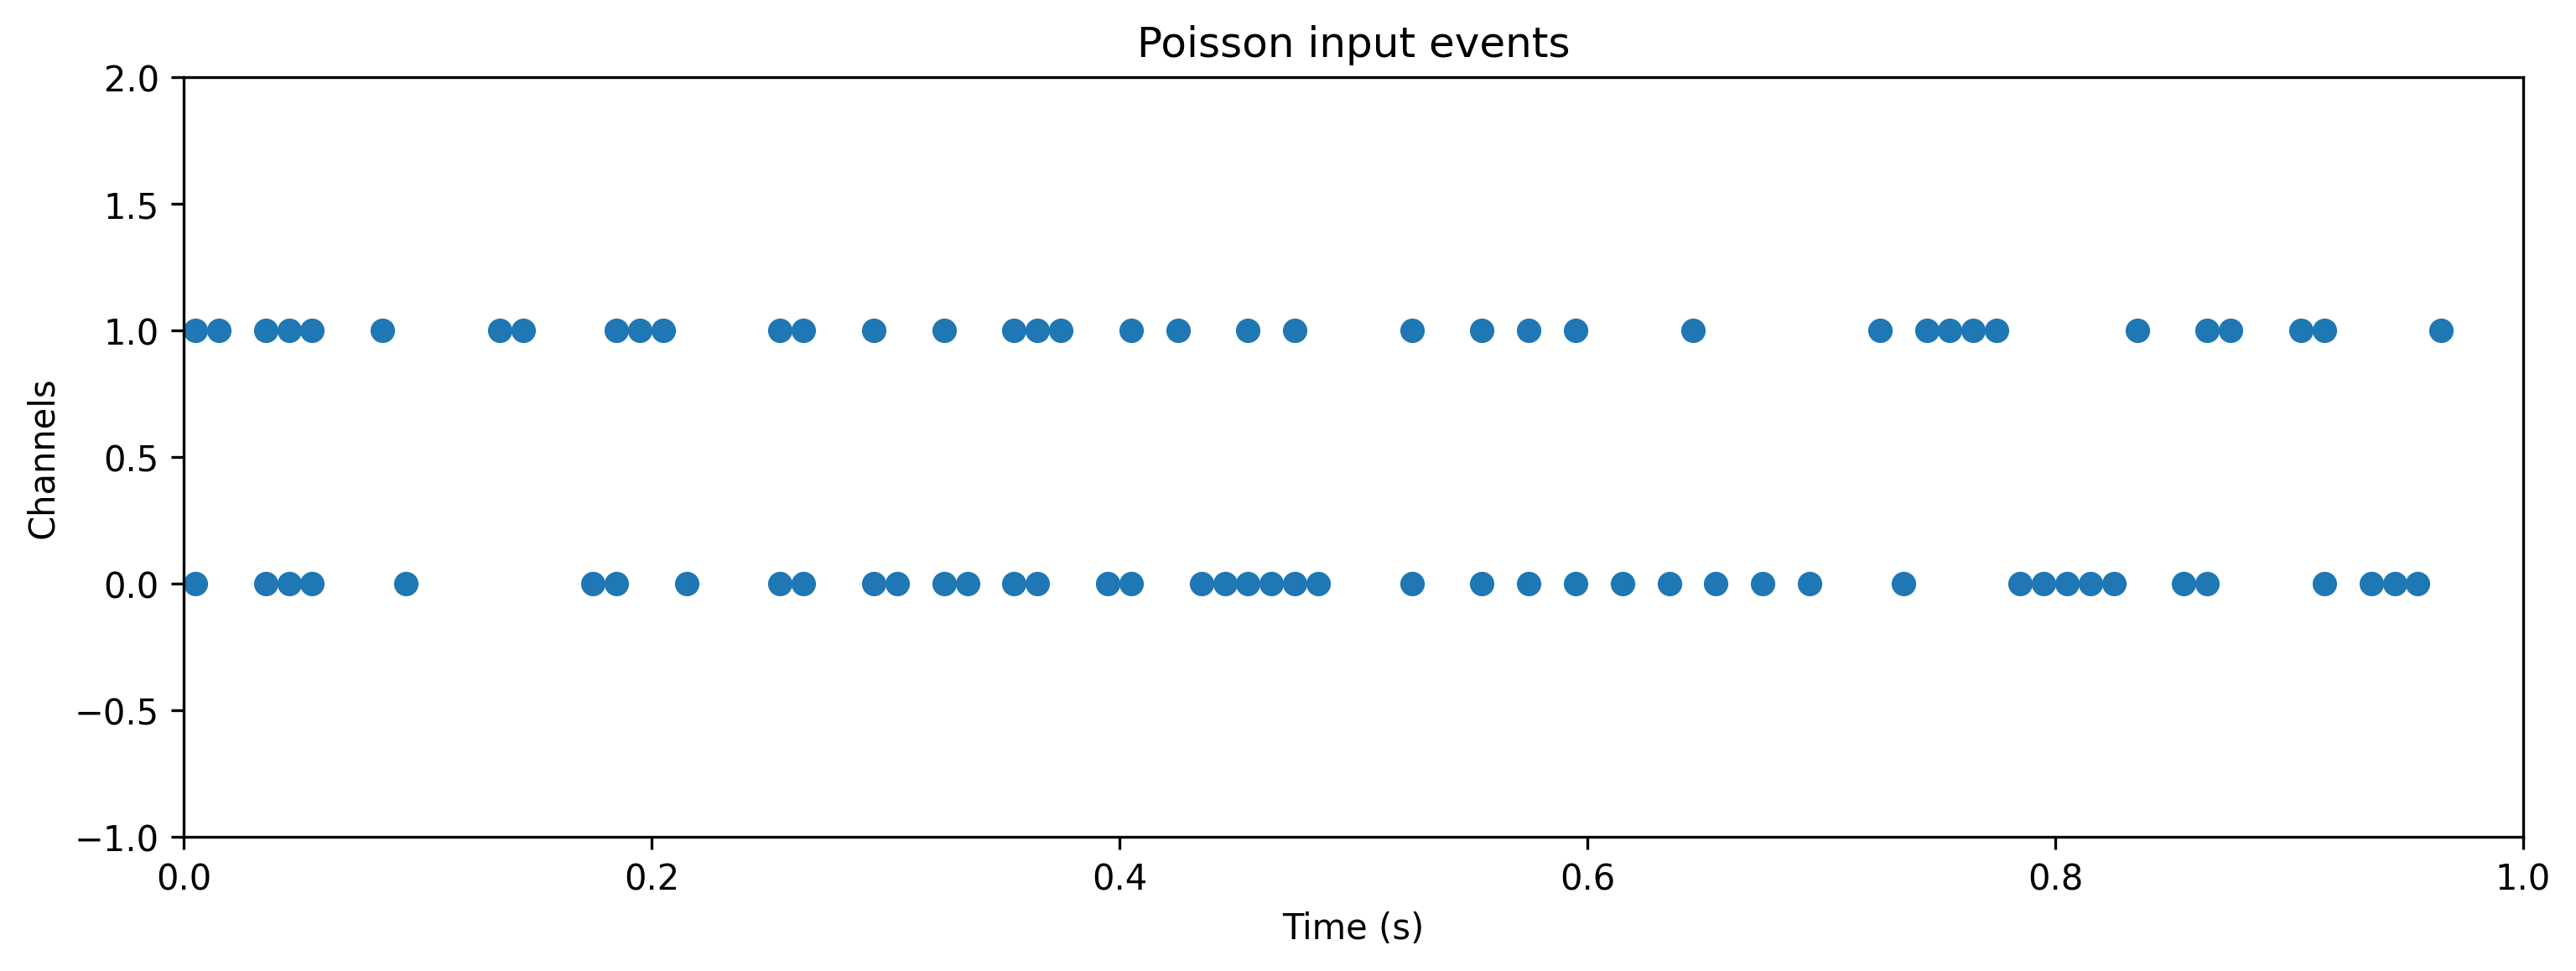

In [8]:
# - Generate some Poisson input
T = 100
f = 0.4
input_spikes = np.random.rand(T, Nin) < f
TSEvent.from_raster(input_spikes, dt, name = 'Poisson input events').plot();

In [9]:
# - Evolve the network on the Xylo HDK via fake auto mode
if db:
    out, _, r_d = modSamna.evolve(input_spikes.astype(int), record = True)
    
    # - Show the internal state variables recorded 
    print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out', 'times'])


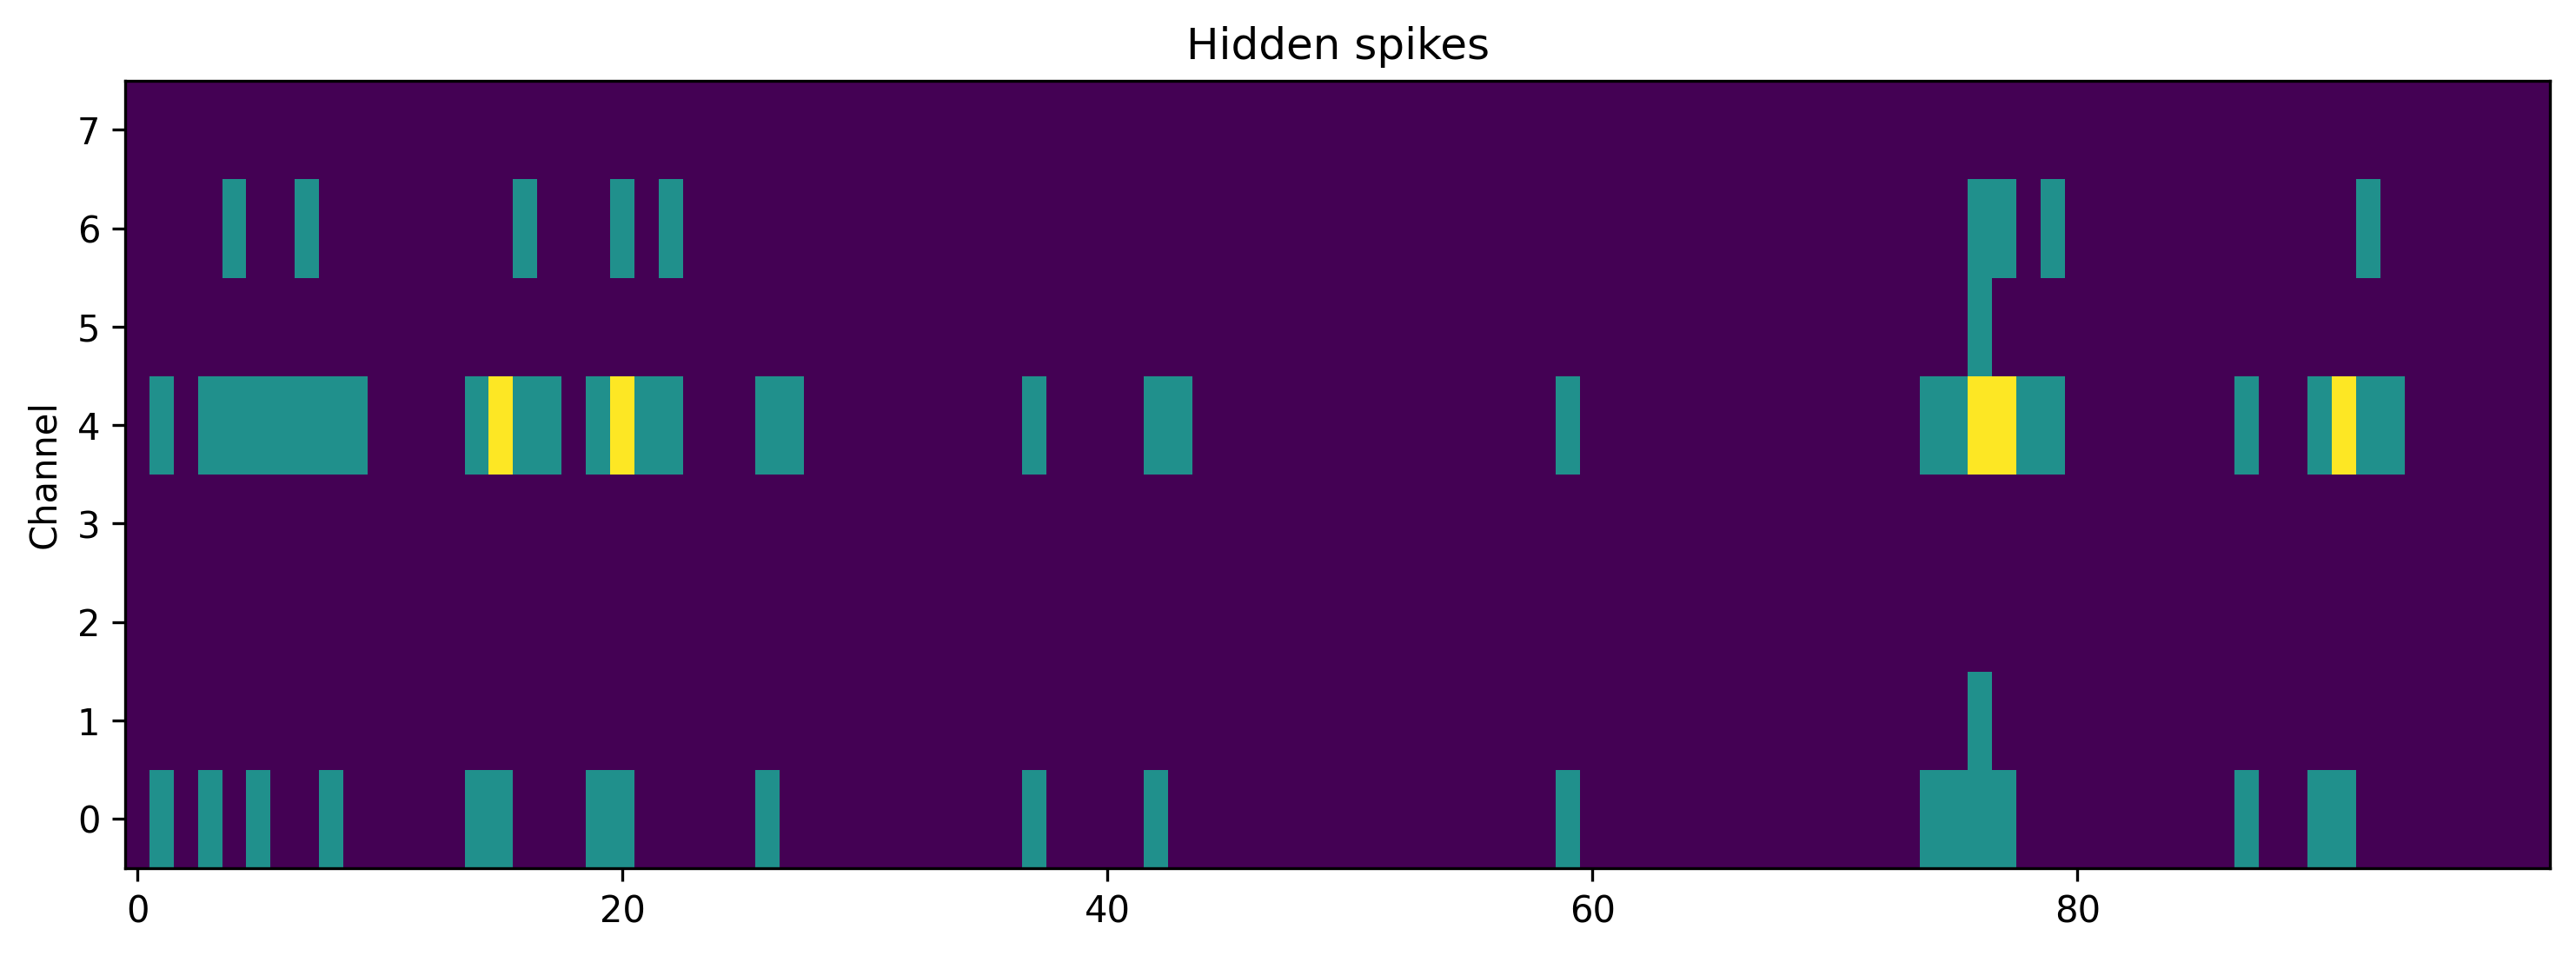

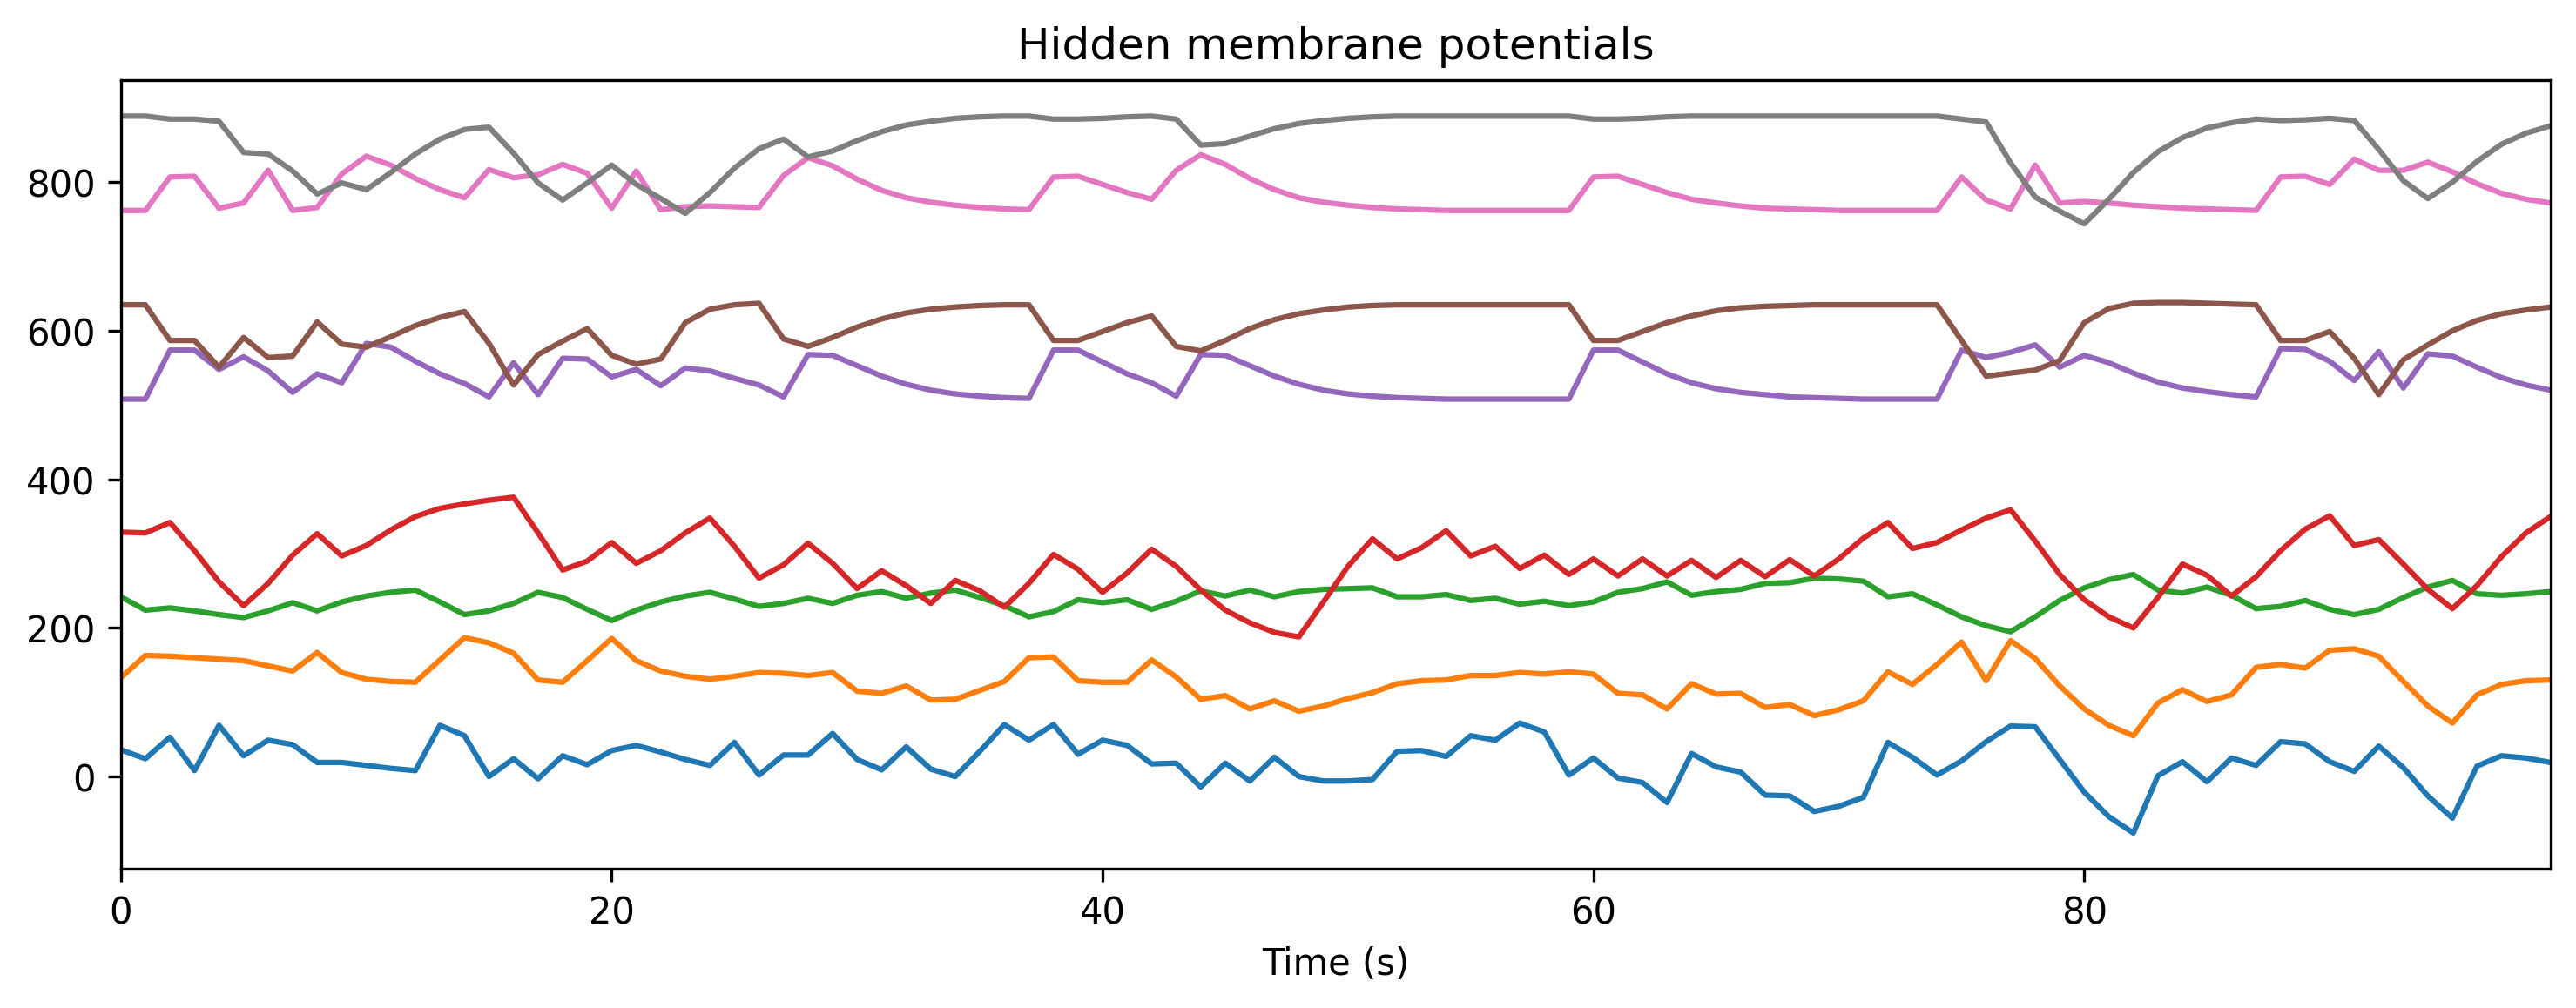

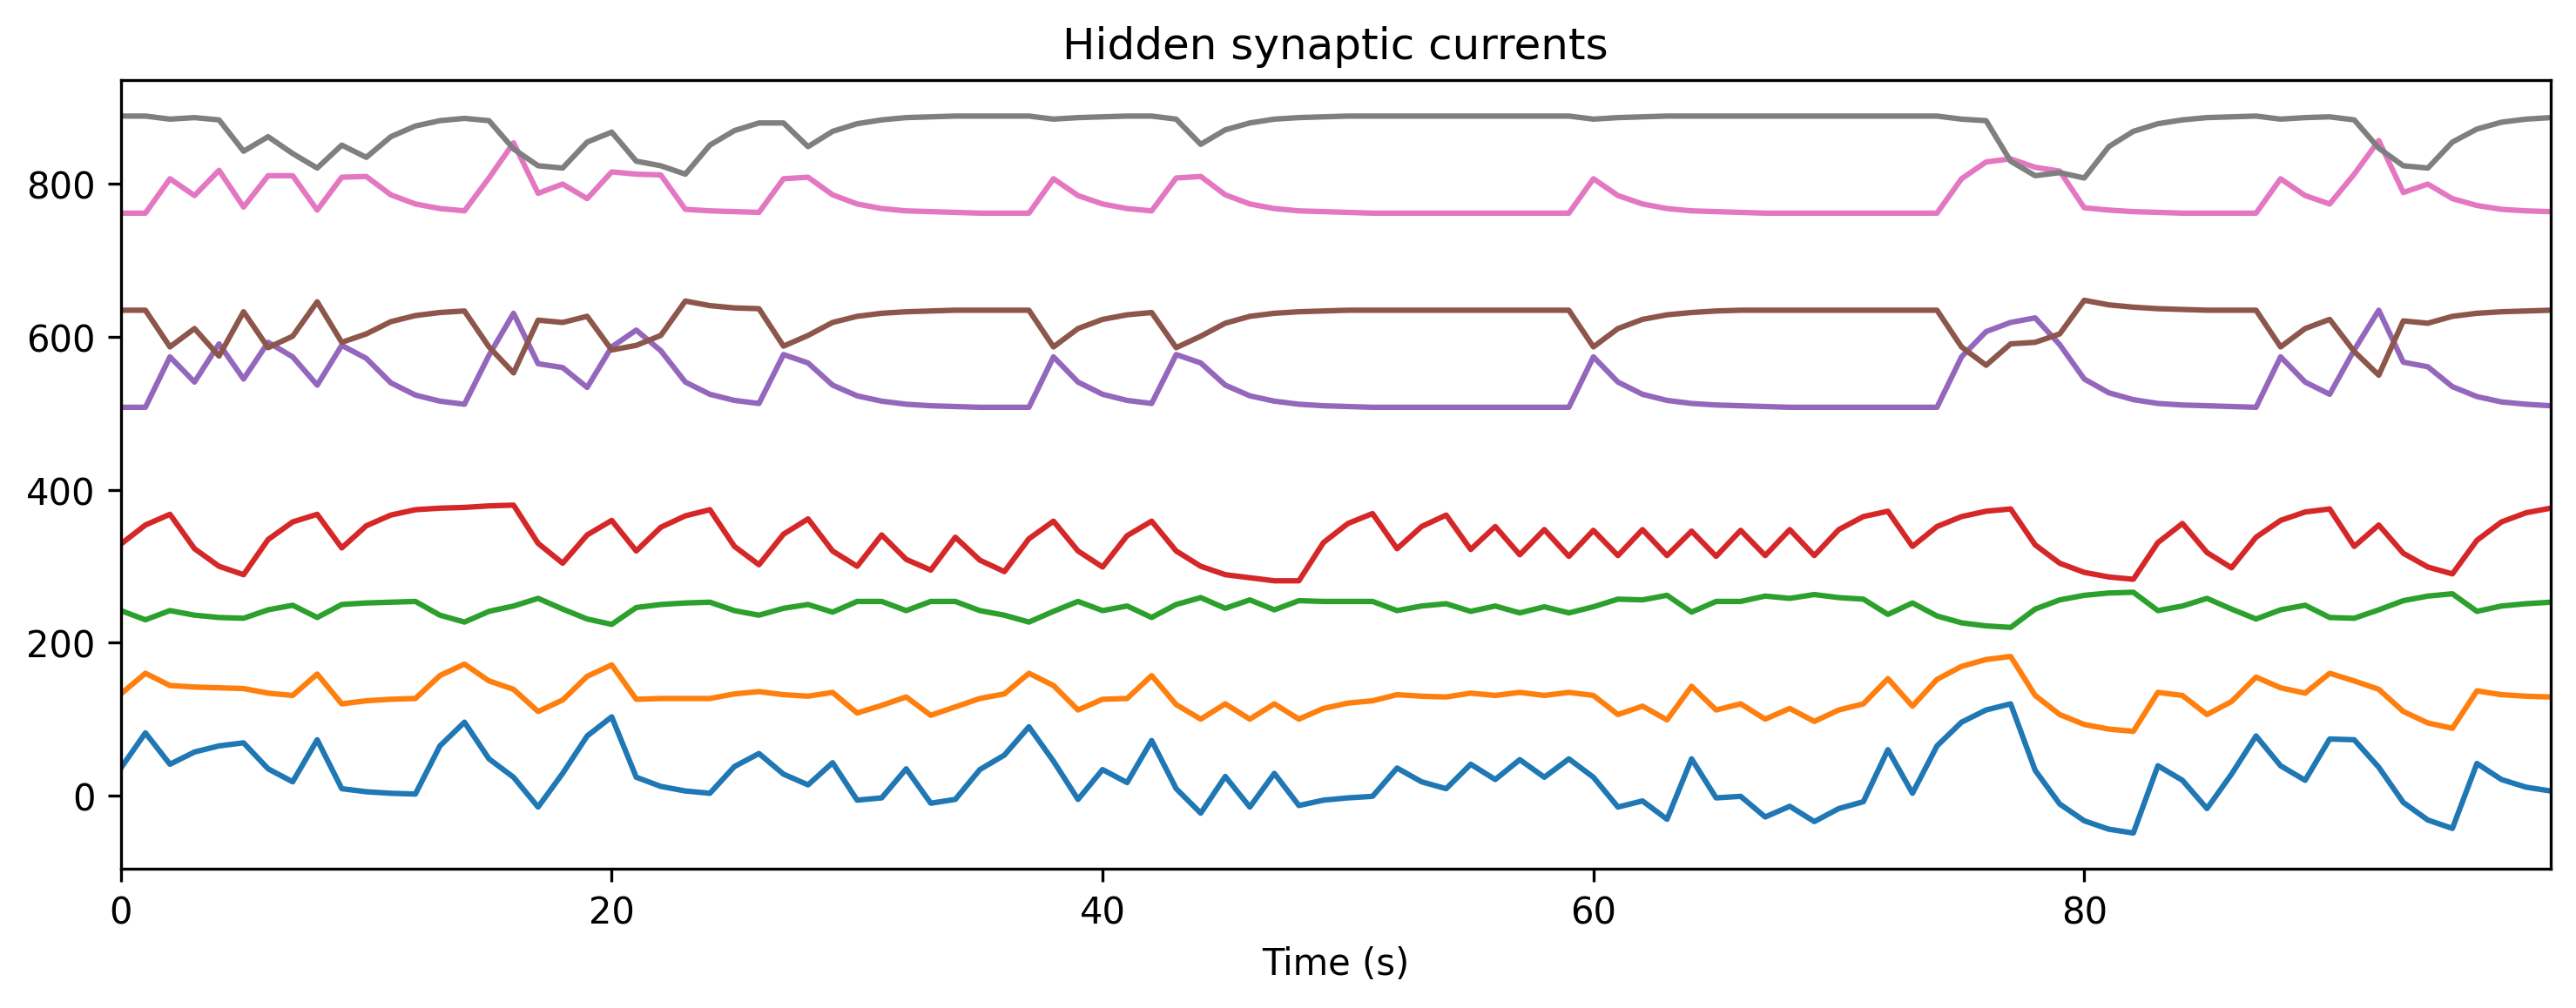

In [11]:
# - Plot some internal state variables
if db:
    plt.figure()
    plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
    plt.title('Hidden spikes')
    plt.ylabel('Channel')
    
    plt.figure()
    TSContinuous(r_d['times'], r_d['Vmem'], name = 'Hidden membrane potentials').plot(stagger = 127)

    plt.figure()
    TSContinuous(r_d['times'], r_d['Isyn'], name = 'Hidden synaptic currents').plot(stagger = 127)

### Step 3: Simulate the HDK using a bit-precise simulator

In [12]:
# - Use rockpool.devices.xylo.XyloIMUSim
modSim = XyloSim.from_config(config, dt=dt)
print(modSim)

XyloSim  with shape (16, 1000, 8)


In [13]:
# - Evolve the input over the network, in simulation
out, _, r_d = modSim(input_spikes, record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out'])


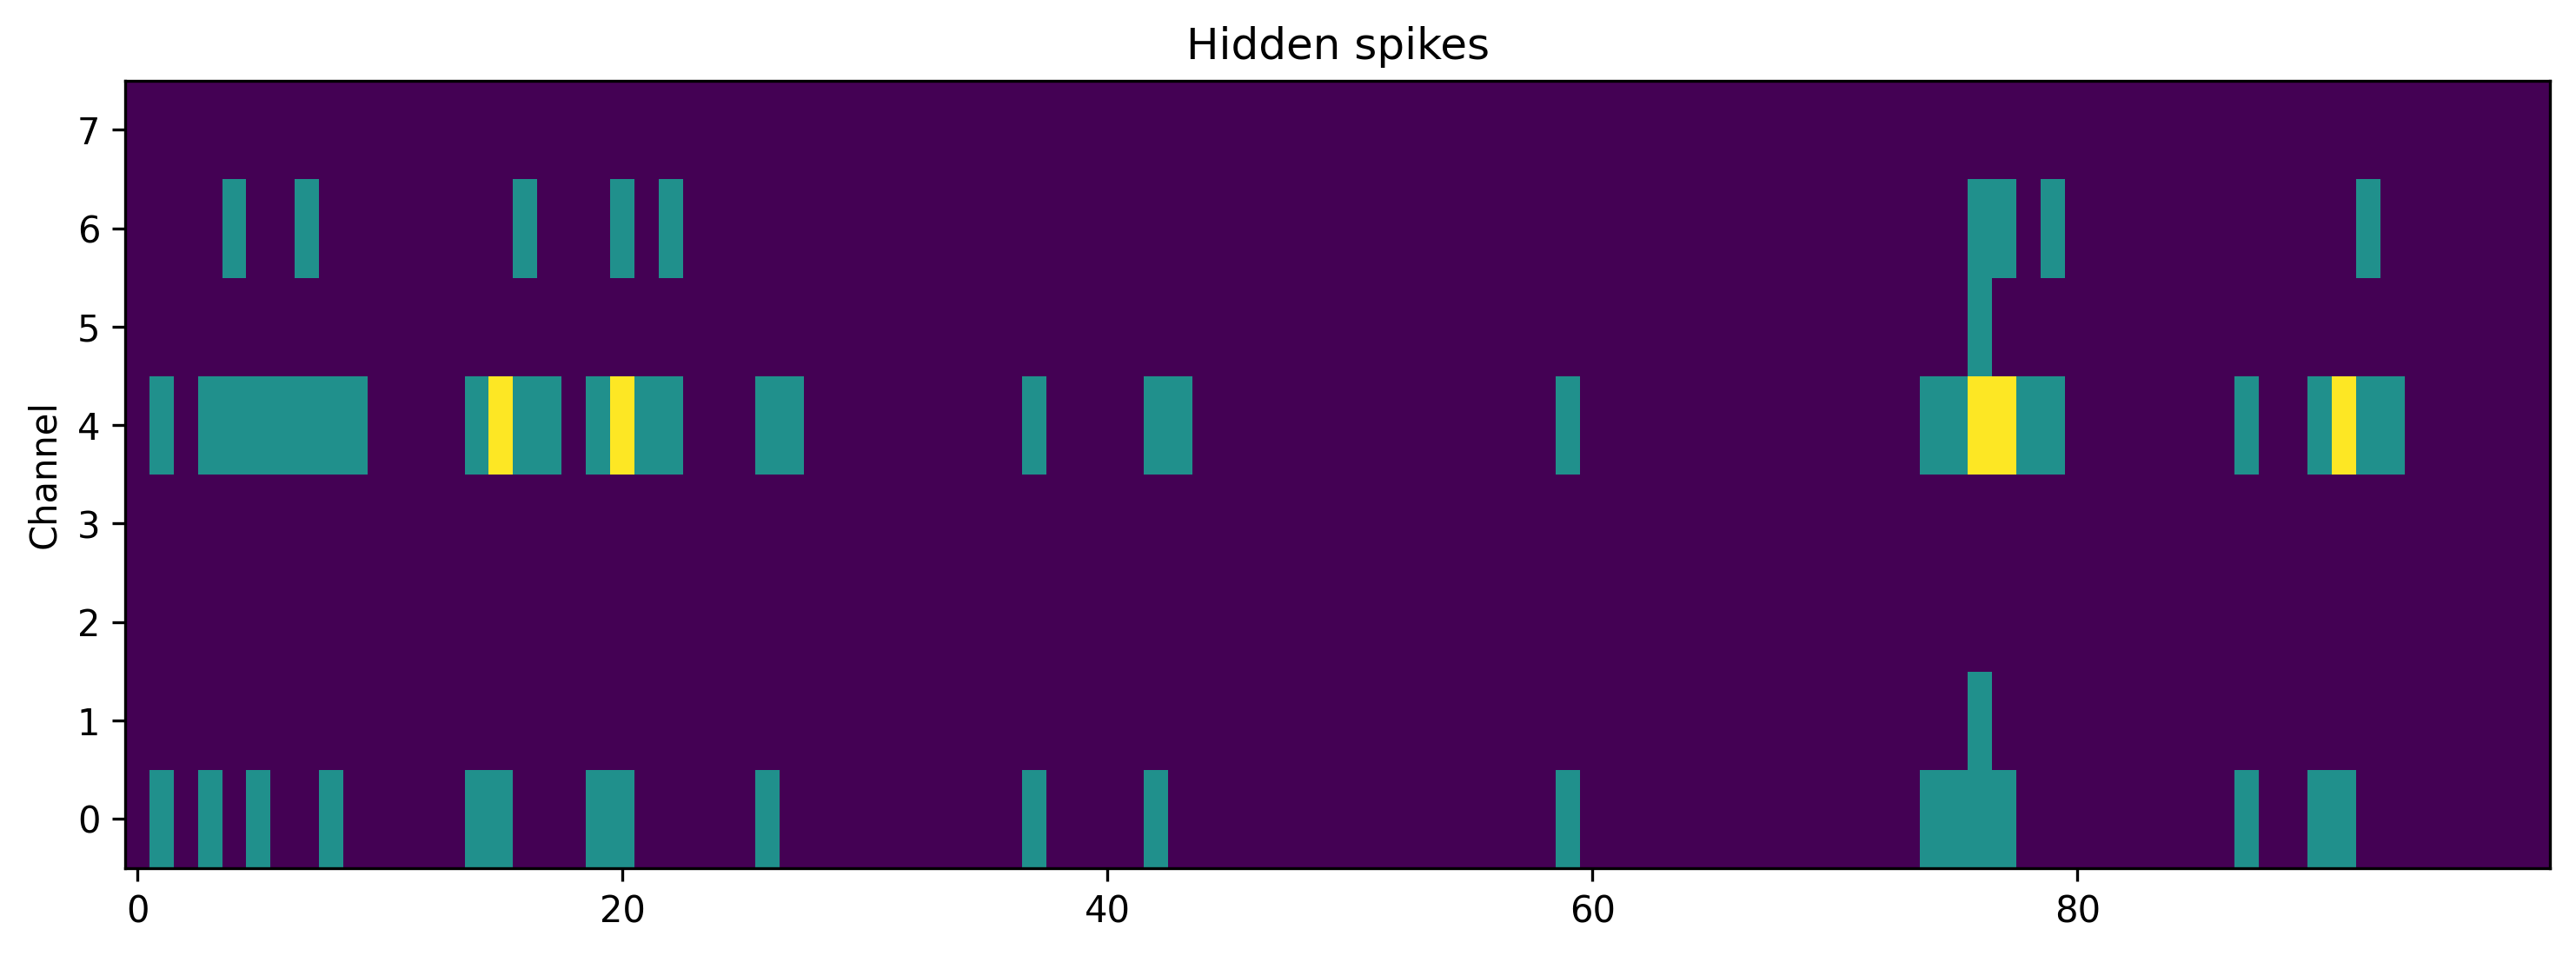

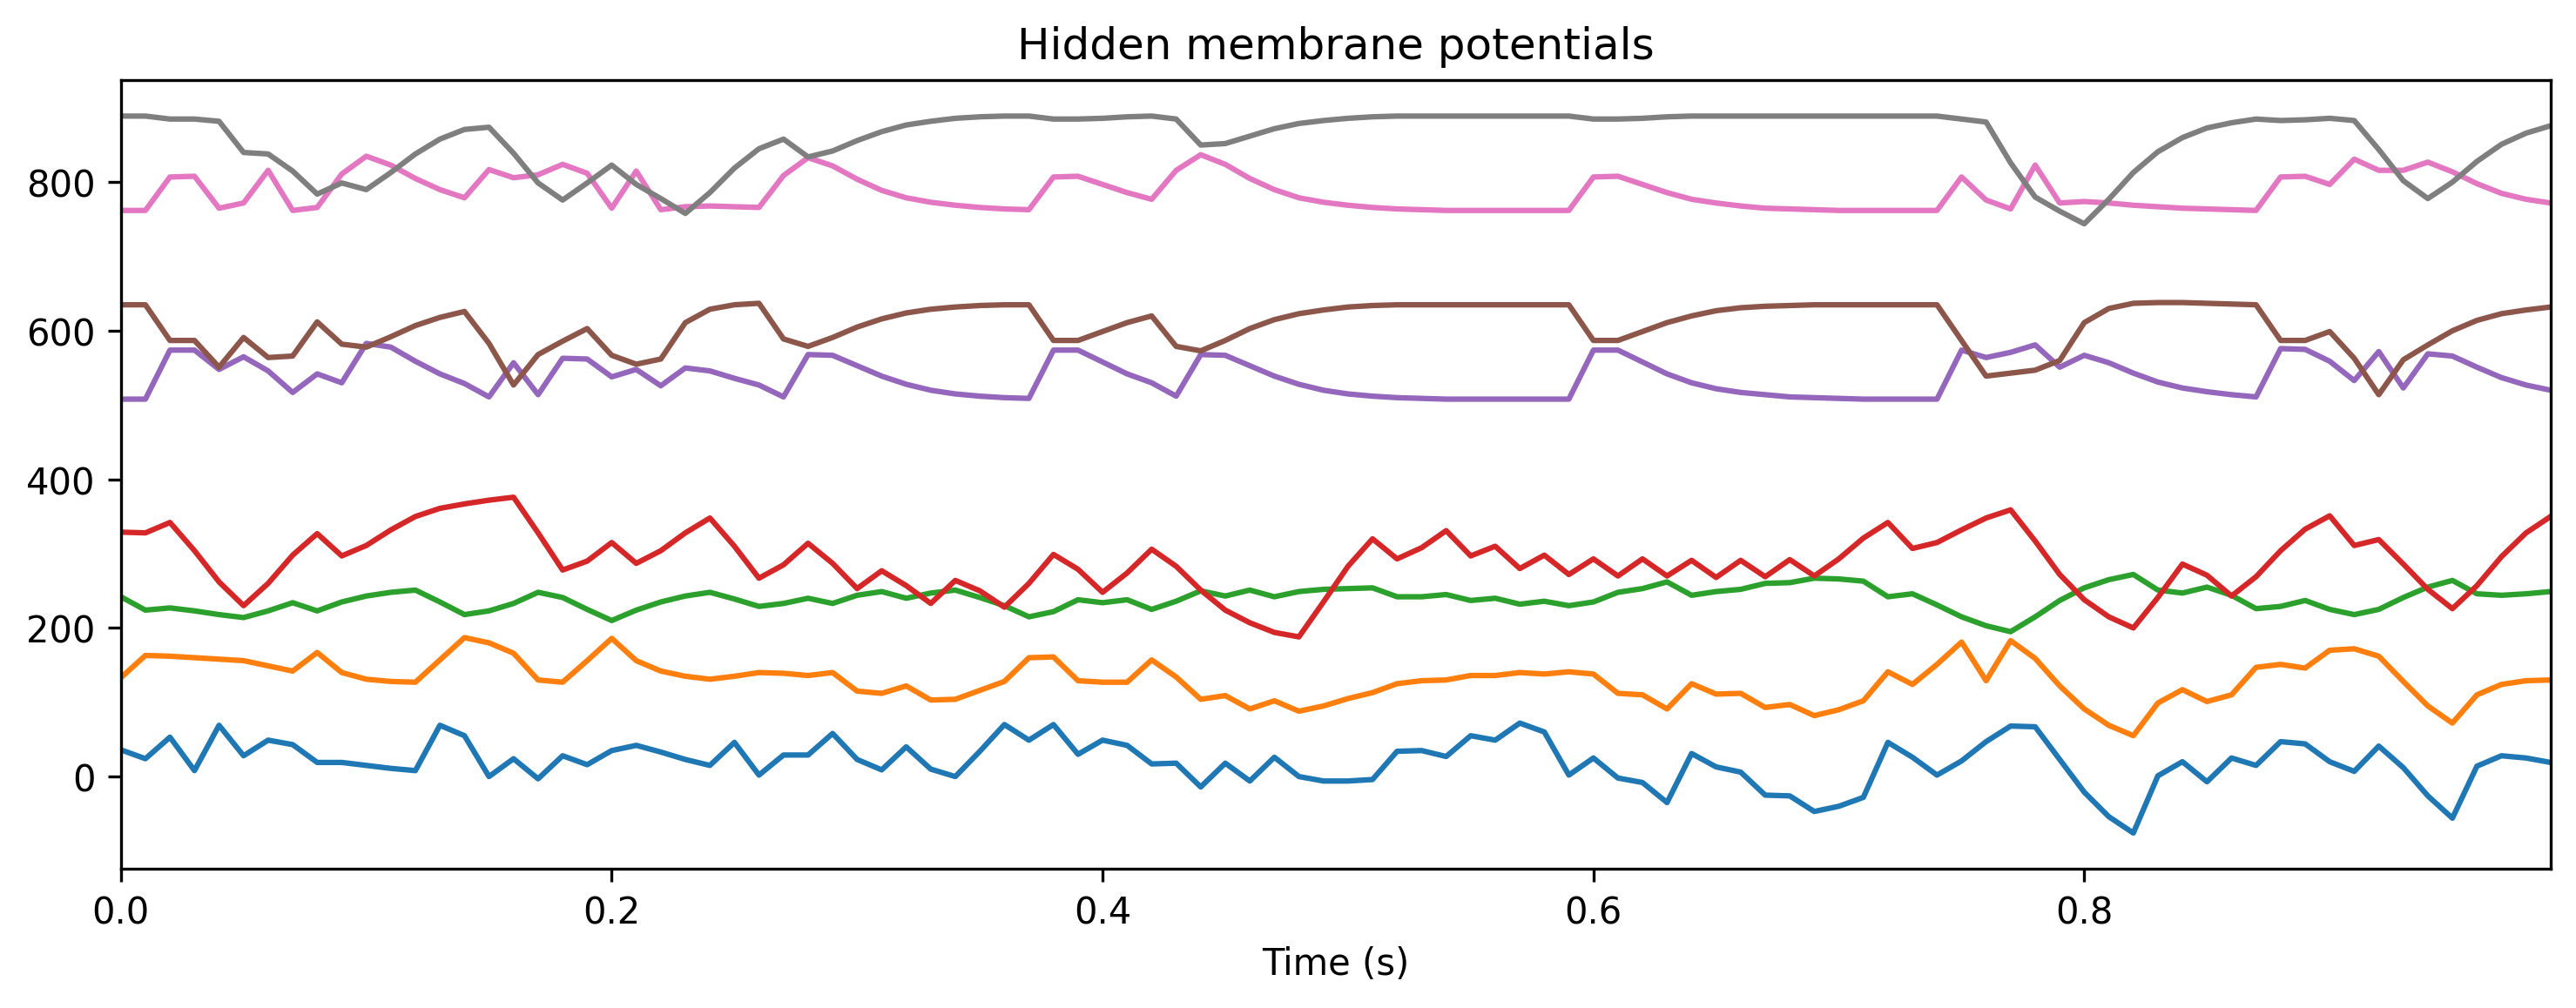

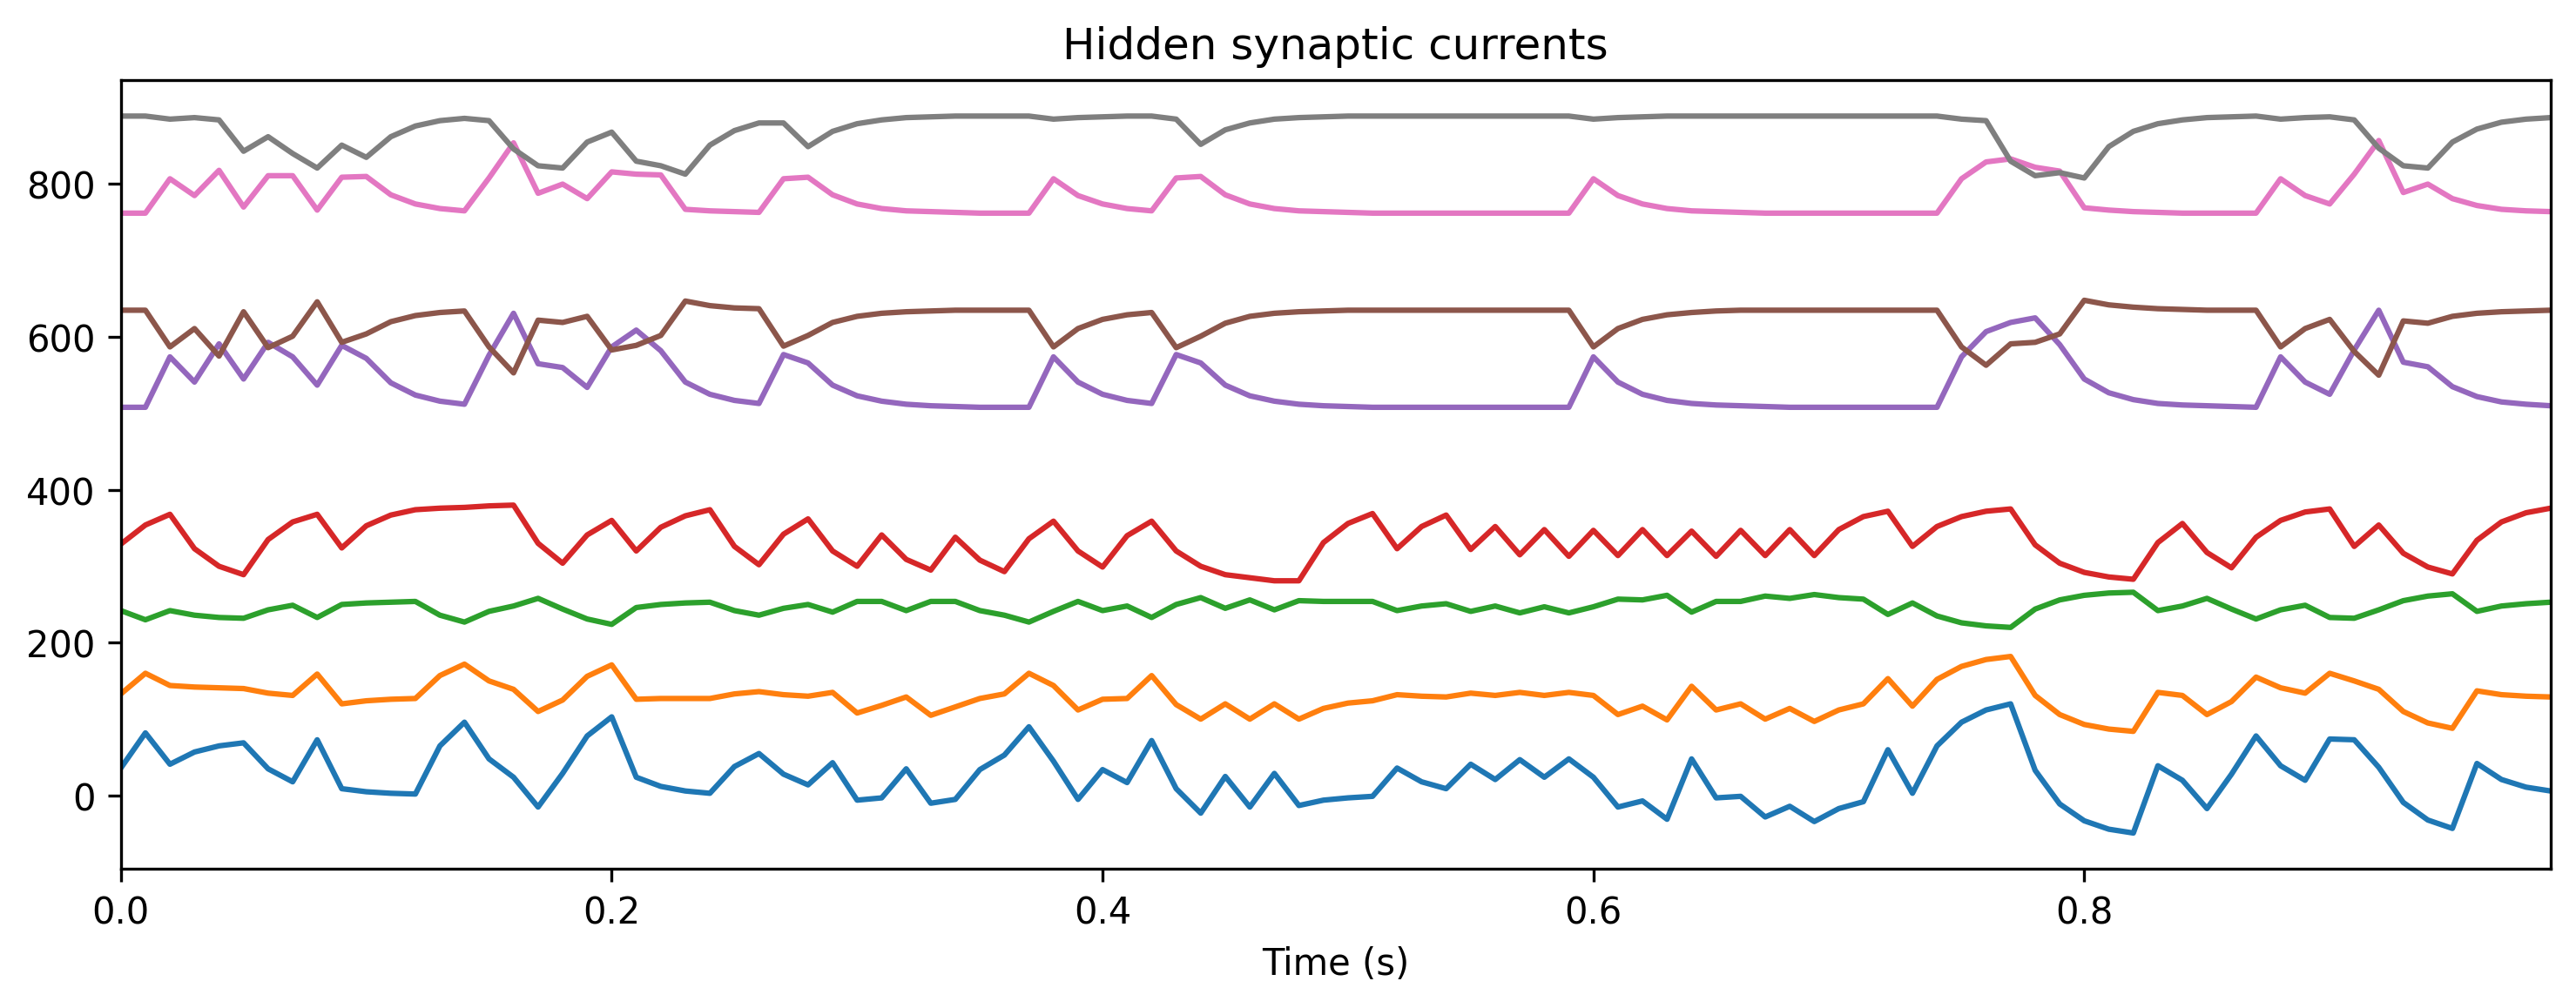

In [14]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous.from_clocked(r_d['Vmem'], dt, name = 'Hidden membrane potentials').plot(stagger = 127)

plt.figure()
TSContinuous.from_clocked(r_d['Isyn'], dt, name = 'Hidden synaptic currents').plot(stagger = 127);

## PART II: Streaming mode

The streaming mode combines the imu interface and SNN inference core modules together in real time using the class :py:class:`.XyloIMUMonitor`.

In this mode you only read the output events from the SNN core, without providing input.

### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [2]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-2

In [3]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}


In [4]:
# - Call the Xylo mapper on the extracted computational graph
spec = mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use rockpool.devices.xylo.config_from_specification to convert it to a hardware configuration
config, is_valid, msg = config_from_specification(**spec)
if not is_valid:
    print(msg)

In [5]:
# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes = putils.find_xylo_imu_boards()
print(xylo_hdk_nodes)

if len(xylo_hdk_nodes) == 0:
    assert False, 'This tutorial requires a connected Xylo IMU HDK to demonstrate.'
else:
    db = xylo_hdk_nodes[0]

### Step 2: Deploy the network on chip and run simulation

In [6]:
# - Use XyloIMUMonitor to deploy to the HDK

output_mode = "Vmem"
T = 10

modMonitor = XyloIMUMonitor(device=db, config=config, dt=dt, output_mode=output_mode)

In [7]:
# - A resultList stack to store the results

class ResultList(object):
    def __init__(self, max_len=100):
        self._list = []
        self.max_len = max_len

    def reset(self):
        self._list = []

    def append(self, num):
        if len(self._list) < self.max_len:
            self._list.append(num)
        else:
            self._list[: self.max_len - 1] = self._list[1:]
            self._list[self.max_len - 1] = num

    def is_full(self):
        if len(self._list) == self.max_len:
            return True
        else:
            return False

    def counts(self, features=[]):
        count = 0
        for _ in self._list:
            if _ in features:
                count += 1
        return count

    def __len__(self):
        return len(self._list)

    def print_result(self):
        return self._list



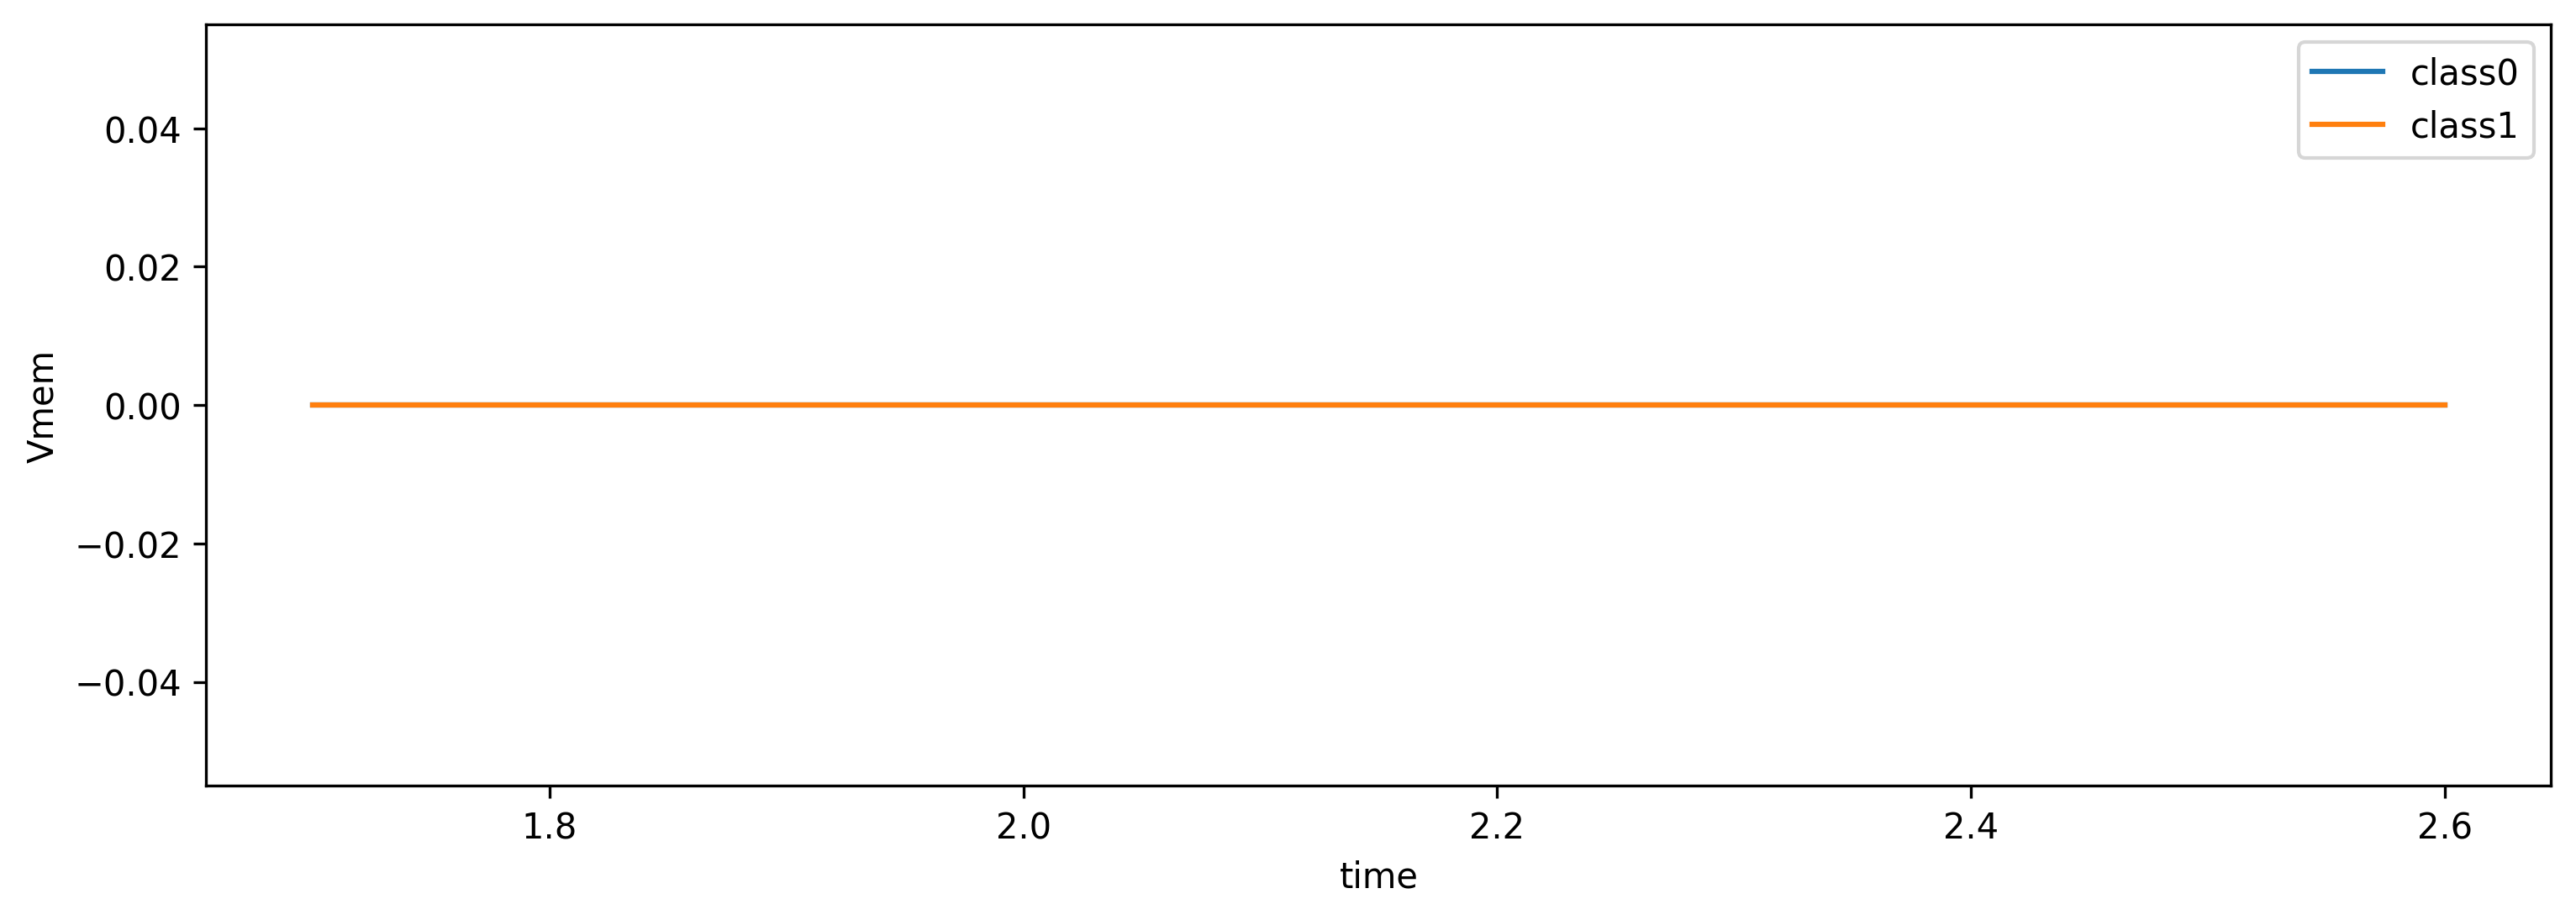

In [8]:
# - Draw a real time image for output channels, you can shake the Xylo IMU device while running

lines = [ResultList(max_len=10) for _ in range(Nout)]
time_base = ResultList(max_len=10)
tt = 0
t_inference = 10.


from time import time

t_start = time()

while (time() - t_start) < t_inference:
    # - Perform inference on the Xylo IMU HDK
    output, _, _ = modMonitor(input_data=np.zeros((T, Nin)))
    if output is not None:
        output = np.max(output, axis=0)
        for i in range(Nout):
            lines[i].append(output[i])

        time_base.append(tt)
        tt += 0.1
        ax_time = time_base.print_result()
        
        for i in range(Nout):
            plt.plot(ax_time, lines[i].print_result(), label=f"class{i}")

        plt.xlabel('time')
        plt.ylabel('Vmem')
        plt.legend()
        plt.pause(0.1)
        display.clear_output(wait=True)